In [1]:
import sys
sys.path.append('..')
import hydra
import torch
from experiments.video_generation import VideoGenerationExperiment
from einops import rearrange
import numpy as np
from scipy.stats import spearmanr
import cv2

/home/s224075134/diffusion-forcing-transformer/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/s224075134/diffusion-forcing-transformer/venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf
from omegaconf import DictConfig
from omegaconf.omegaconf import open_dict
# Initialize Hydra
# The version_base is optional but recommended to avoid deprecation warnings
with initialize(version_base=None, config_path="../configurations"):
    # Compose the config - replace "config_name" with your actual config name
    # You can also override values here if needed
    cfg = compose(
        config_name="config", 
        overrides=[
            'algorithm=contrastive_dfot_video', 
            "experiment=video_generation",
            'dataset=ucf_101',
            'experiment.tasks=[validation]',
            'experiment.validation.data.shuffle=False',
            'dataset.context_length=4',
            'dataset.n_frames=12',
            'experiment.validation.batch_size=4',
            'algorithm.tasks.prediction.history_guidance.name=vanilla'
            ],
        return_hydra_config=True
    )
    
    # Now you have the config in the 'cfg' variable
    # You can print it, access values, etc. without running your actual application
    # print(OmegaConf.to_yaml(cfg))
    
    # Access config values
    # print(f"Some value from config: {cfg.some_key}")
cfg_choice = cfg['hydra'].runtime.choices
with open_dict(cfg):
    if cfg_choice["experiment"] is not None:
        cfg.experiment._name = cfg_choice["experiment"]
    if cfg_choice["dataset"] is not None:
        cfg.dataset._name = cfg_choice["dataset"]
    if cfg_choice["algorithm"] is not None:
        cfg.algorithm._name = cfg_choice["algorithm"]
    

exp = VideoGenerationExperiment(cfg, None, None)
algo = exp._build_algo()
algo = algo.to('cuda:0')

/home/s224075134/diffusion-forcing-transformer/venv/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


{'hydra': {'run': {'dir': '${output_dir}/${now:%Y-%m-%d}/${now:%H-%M-%S}'}, 'sweep': {'dir': 'multirun/${now:%Y-%m-%d}/${now:%H-%M-%S}', 'subdir': '${hydra.job.num}'}, 'launcher': {'_target_': 'hydra._internal.core_plugins.basic_launcher.BasicLauncher'}, 'sweeper': {'_target_': 'hydra._internal.core_plugins.basic_sweeper.BasicSweeper', 'max_batch_size': None, 'params': None}, 'help': {'app_name': '${hydra.job.name}', 'header': '${hydra.help.app_name} is powered by Hydra.\n', 'footer': 'Powered by Hydra (https://hydra.cc)\nUse --hydra-help to view Hydra specific help\n', 'template': '${hydra.help.header}\n== Configuration groups ==\nCompose your configuration from those groups (group=option)\n\n$APP_CONFIG_GROUPS\n\n== Config ==\nOverride anything in the config (foo.bar=value)\n\n$CONFIG\n\n${hydra.help.footer}\n'}, 'hydra_help': {'template': "Hydra (${hydra.runtime.version})\nSee https://hydra.cc for more info.\n\n== Flags ==\n$FLAGS_HELP\n\n== Configuration groups ==\nCompose your con

In [3]:
output = torch.load('/weka/s224075134/temporal_diffusion/diffusion-forcing-transformer/outputs/2025-04-13/19-38-15/representations/representation_0.pt')

xs = output['xs']
#xs = algo._unnormalize_x(xs)

rep = output['representation']
noise_levels = output['noise_levels']
xs_pred = output['xs_pred']

In [ ]:
noise_levels[dd]

torch.Size([4, 12])

In [4]:
def compute_optical_flow(prev_frame, next_frame):
    flow = cv2.calcOpticalFlowFarneback(
        prev_frame,
        next_frame, 
        None, 
        0.5,    # pyramid scale
        3,      # levels
        15,     # window size
        3,      # iterations
        5,      # pixel neighborhood
        1.2,    # poly sigma
        0       # flags
    )

    magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            
    # Normalize magnitude for better visualization
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return magnitude

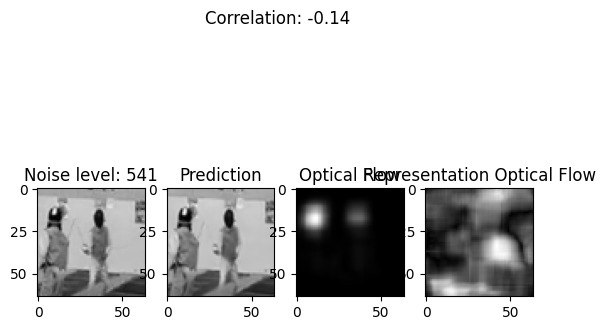

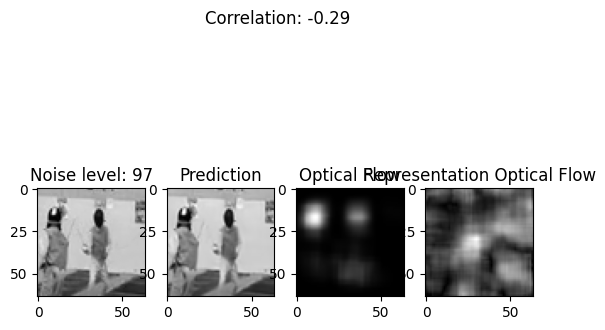

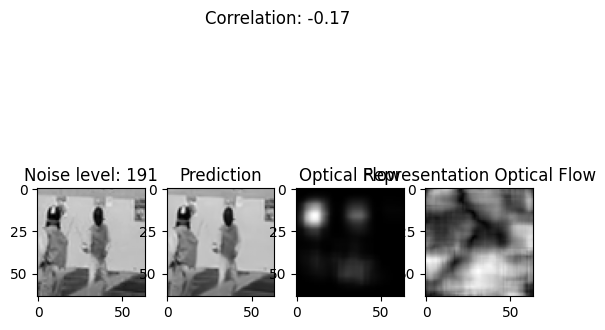

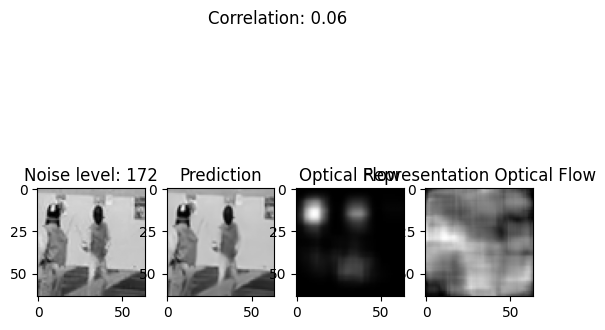

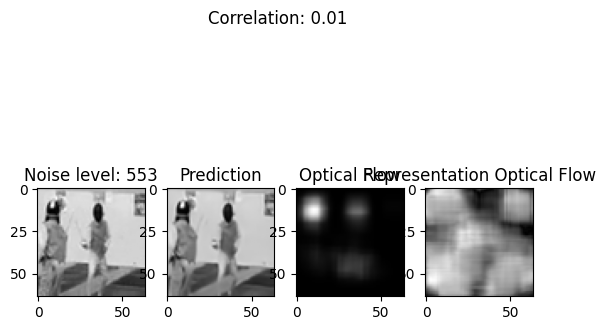

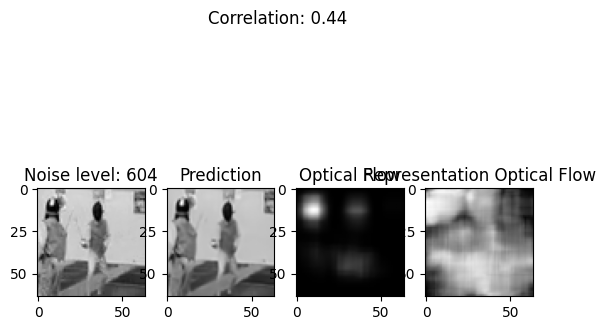

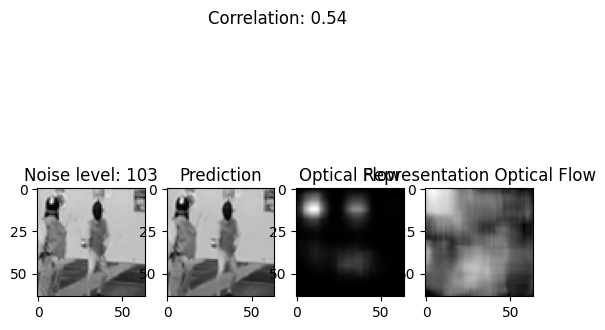

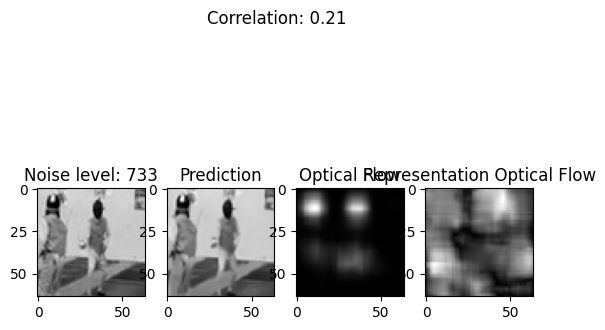

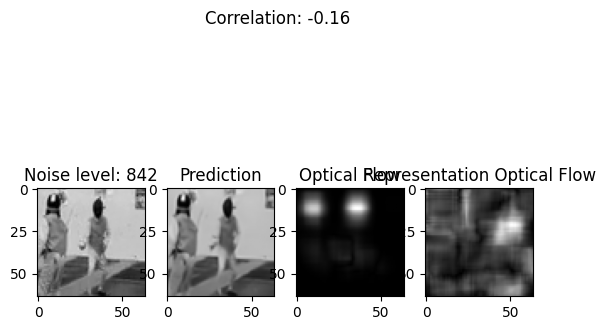

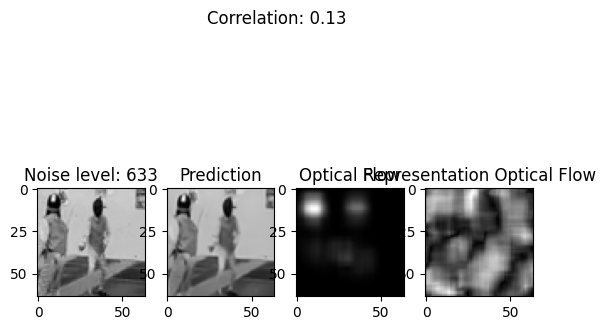

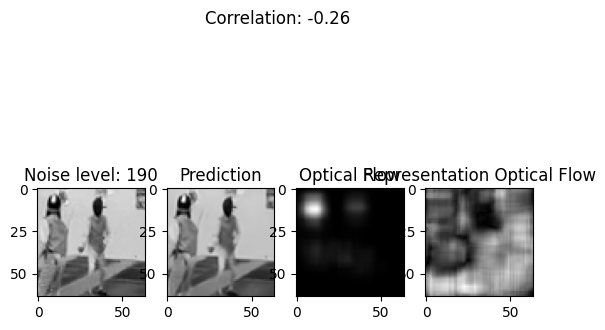

In [7]:
import matplotlib.pyplot as plt

sample_idx = 0
for i in range(11):
    prev_frame = xs[sample_idx, i].cpu().numpy().transpose(1, 2, 0)
    next_frame = xs[sample_idx, i+1].cpu().numpy().transpose(1, 2, 0)

    prev_frame = 0.299*prev_frame[:, :, 0] + 0.587*prev_frame[:, :, 1] + 0.114*prev_frame[:, :, 2]
    next_frame = 0.299*next_frame[:, :, 0] + 0.587*next_frame[:, :, 1] + 0.114*next_frame[:, :, 2]
    
    rep_prev_frame = rep[sample_idx, i].cpu().numpy().transpose(1, 2, 0)
    rep_next_frame = rep[sample_idx, i+1].cpu().numpy().transpose(1, 2, 0)

    rep_prev_frame = np.average(rep_prev_frame[:, :, :], axis=2)
    rep_next_frame = np.average(rep_next_frame[:, :, :], axis=2) 
    # normalize to 0-1
    rep_prev_frame = cv2.normalize(rep_prev_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    rep_next_frame = cv2.normalize(rep_next_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    pred_prev_frame = xs_pred[sample_idx, i].cpu().numpy().transpose(1, 2, 0)
    pred_prev_frame = 0.299*pred_prev_frame[:, :, 0] + 0.587*pred_prev_frame[:, :, 1] + 0.114*pred_prev_frame[:, :, 2]

    optical_flow = compute_optical_flow(prev_frame, next_frame)
    rep_optical_flow = compute_optical_flow(rep_prev_frame, rep_next_frame)

    # optical_flow = next_frame - prev_frame
    # rep_optical_flow = rep_next_frame - rep_prev_frame

    # norm rep_optical_flow to 0-1
    rep_optical_flow = cv2.normalize(rep_optical_flow, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    noise_level = noise_levels[sample_idx, i].cpu().numpy()

    # correlation
    corr = np.corrcoef(optical_flow.flatten(), rep_optical_flow.flatten())[0, 1]

    # imshow, 2 images side by side
    plt.subplot(1, 4, 1)
    plt.imshow(prev_frame, cmap='gray')
    plt.title('Noise level: ' + str(noise_level))
    plt.subplot(1, 4, 2)
    plt.imshow(pred_prev_frame, cmap='gray')
    plt.title('Prediction')
    plt.subplot(1, 4, 3)
    plt.imshow(optical_flow, cmap='gray')
    plt.title('Optical Flow')
    plt.subplot(1, 4, 4)
    plt.imshow(rep_optical_flow, cmap='gray')
    plt.title('Representation Optical Flow')
    plt.suptitle(f'Correlation: {corr:.2f}')
    plt.show()

    # plt.imshow(0.299*gt_frame[:, :, 0] + 0.587*gt_frame[:, :, 1] + 0.114*gt_frame[:, :, 2], cmap='gray')
    # plt.imshow(magnitude, cmap='viridis', alpha=0.5)
    # plt.show()


# Display the optical flow magnitude
# cv2.imshow('Optical Flow Magnitude', magnitude)

In [57]:
i = 0
f = 5
corr = np.corrcoef(xs[i,f].flatten().cpu() - xs[i,f+1].flatten().cpu(), xs[i,f+1].cpu().flatten() - xs[i,f+2].flatten().cpu())[0, 1]
corr


0.10233763452906654

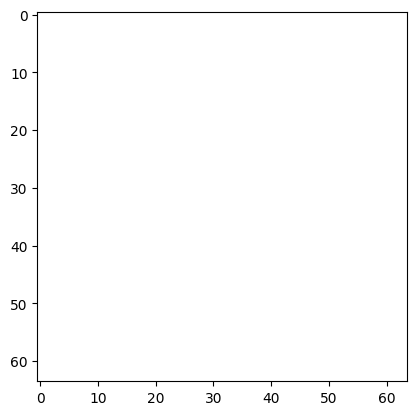

In [50]:
from matplotlib import rc
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

norm_xs = algo._unnormalize_x(xs)
imgs = torch.rand(10,3,128,128)
imgs = imgs.permute(0,2,3,1) # Permuting to (Bx)HxWxC format
frames = [[ax.imshow(rearrange(norm_xs[0][i].cpu(), 'c h w -> h w c'))] for i in range(len(norm_xs[0]))]

ani = animation.ArtistAnimation(fig, frames)
ani